# Interpreting FGL weights

[Todo] 
**Thoughts**: Importance of intermediate representations are normally misleading due to changes in variance and correlations that occur. However, maybe weight norm avoids all of those? Afterall, it does make the norm remain the same... Not exactly the same as keeping the same distribution, but might be all we really need?

**Neuroscientific interpretation**: Get started

## Notational warning to readers
Math subscript are in (position, filter) order but the implementation of FGL is in (filter, position) order. Thank you, PyTorch!

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import time
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import torch
import nibabel
import data.constants as constants
import nilearn.masking as masking
import numpy as np
import pandas as pd
import nibabel
from nilearn.image import load_img, resample_img, crop_img, threshold_img, math_img
import nilearn.image as niimg
import nilearn.masking as masking
from nilearn import plotting
import itertools
import torch
from torch import autograd
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gcn.modules import (
    classifiers,
)
import utils.utils as utils
from data import (
    dataset,
    constants,
    ward_tree,
)
import scipy
import scipy.special
mask = nibabel.load("/data/hcp/hcp_mask.nii.gz")
from collections import defaultdict
from torch import _weight_norm, norm_except_dim


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Interpretability for a model
`ds` determines which dataset. Changing it requires re-running the entire notebook.

In [61]:
md = "smallerfgl_213_sum_tree"
prefix = "test"
ds = "camcan0"
fc_chk = torch.load("/data/brain_/gcn/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format("fc", ds))

chk = torch.load("/data/brain_/gcn/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format(md, ds))
args = torch.load("/data/brain_/gcn/outputs/multi_run/{}/{}/args.checkpoint".format(md, ds))
splits, meta = dataset.get_splits(
    args.study,
    args.outer_folds,
    1,
    args.dset_seed,
    random_outer=args.outer_frac,  # test, always. Not CV
    random_inner=0.0,  # No validation.
    masked=classifiers.masked[args.classifier_type],
    downsampled=args.downsampled,
    normalization=args.normalization,
    not_lazy=args.not_lazy
)

model = classifiers.versions[args.classifier_type](args, loadable_state_dict=chk['model'])
model.load_state_dict(chk['model'])
model = model.cuda()
dpm = nn.DataParallel(model)
model = model.eval()

fc = classifiers.versions["fc"](args, loadable_state_dict=fc_chk["model"])
with torch.no_grad():
    fc_weight = fc_chk['model']['net.0.weight_g'] * fc_chk['model']['net.0.weight_v']
fc_imgs = [masking.unmask(fc_weight[i].cpu().numpy(), mask) for i in range(fc_weight.shape[0])]

n_regions=32 >= level_size=32 is not allowed. setting n_regions < level_size
Using corrected initialization
FGL: Using tree optimization
Using corrected initialization
FGL: Using tree optimization
Using corrected initialization
FGL: Using tree optimization


### Class names

In [62]:
args.meta['i2c']

{0: 'camcan-AudVid600',
 1: 'camcan-AudVid300',
 2: 'camcan-AudVid1200',
 3: 'camcan-VidOnly',
 4: 'camcan-AudOnly'}

### Visualization of logistic regression weights
Change the `cls` variable in the next cell and run

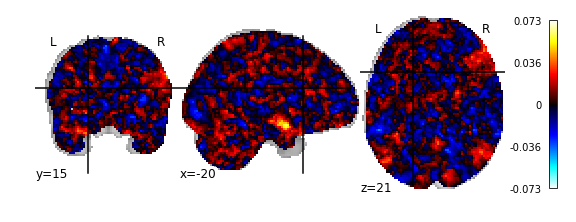

In [51]:
cls = 22
plotting.plot_stat_map(fc_imgs[cls], cut_coords=[-20, 15, 21])
# plotting.plot_stat_map(niimg.smooth_img(imgs[0], 'fast'))

# fcwt_imgs = [masking.unmask(fc.net[0].weight[i].detach().cpu().numpy(), mask) for i in range(fc_weight.shape[0])]
# plotting.plot_stat_map(fcwt_imgs[cls])

In [42]:
np.linalg.matrix_rank(chk['model']['downsample2.ft_weight'].cpu().numpy())

KeyError: 'downsample2.ft_weight'

### Mathing our way to interpreting FGL
One FGL layer is $$o = A(x^{\top}v)\cdot u)$$
Expanding it out, it becomes $$o_{p,j} = \sum_{i\in Children(p)} u_{i,j} \sum_{k=1}^{c_{in}} x_{i,k}, v_{k,j}$$

We stack this thrice. Layer 1 first,
$$o_{p,j}^{(1)} = \sum_{i_1\in Children^{(1)}(p)} u_{i_1,j}^{(1)} \sum_{k=1}^{c_{in}} x_{i_1, k} v_{k, j}^{(1)}$$
Layer 2 is:
$$o_{p,j}^{(2)} = \sum_{i\in Children^{(2)}(p)} u_{i,j}^{(2)} \sum_{k=1}^{c_{in}^{(2)}} o_{i, k}^{(1)} v_{k, j}^{(2)}$$
$$o_{i_3,j}^{(2)} = \sum_{i_2\in Children^{(2)}(i_3)} u_{i_2,j}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (\sum_{i_1\in Children^{(1)}(i_2)} u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, j}^{(2)}$$

Layer 3 is:
$$o_{p,j}^{(3)} = \sum_{i\in Children^{(3)}(p)} u_{i,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} o_{i, k_3}^{(2)} v_{k_3, j}^{(3)}$$

$$o_{p,j}^{(3)} = \sum_{i_3\in Children^{(3)}(p)} u_{i_3,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} (\sum_{i_2\in Children^{(2)}(i_3)} u_{i_2,k_3}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (\sum_{i_1\in Children^{(1)}(i_2)} u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, k_3}^{(2)}) v_{k_3, j}^{(3)}$$

Rearranging terms
$$o_{p,j}^{(3)} = \sum_{k_3}^{c_{in}^{(3)}} \sum_{k_2}^{c_{in}^{(2)}} \sum_{k_1}^{c_{in}^{(1)}} \sum_{i_3\in Children^{(3)}(p)} \sum_{i_2\in Children^{(2)}(i_3)} \sum_{i_1\in Children^{(1)}(i_2)} x_{i_1, k_1} u_{i_3, j}^{(3)} u_{i_2, k_3}^{(2)} u_{i_1, k_2}^{(1)} v_{k_1, k_2}^{(1)} v_{k_2, k_3}^{(2)} v_{k_3, j}^{(3)}$$

Since each FGL layer follows a tree structure, Each $x_{i_1}$ affects only ONE $o_{p, :}$... so given a $i_1$, there is only one $i_2, i_3, p$. Hence, we rewrite our equation as:
$$o_{p, j}^{(3)} = x_{i_1, k_1} \sum_{k_3}^{c_{in}^{(3)}} \sum_{k_2}^{c_{in}^{(2)}} u_{i_3, j}^{(3)} u_{i_2, k_3}^{(2)} u_{i_1, k_2}^{(1)} v_{k_1, k_2}^{(1)} v_{k_2, k_3}^{(2)} v_{k_3, j}^{(3)} $$
for $i_2, i_3, p$ determined by the parents relationship

Further, $$y^{(c)} = \sum_{p, j} w^{(c)}_{p, j} o^{(3)}_{p, j}$$

## Importance with bias accounted for
$$o_{p,j}^{(1)} = b^{(1)}_{p, j} + \sum_{i_1\in Children^{(1)}(p)} u_{i_1,j}^{(1)} \sum_{k=1}^{c_{in}} x_{i_1, k} v_{k, j}^{(1)}$$


$$o_{p,j}^{(3)} = b^{(3)}_{p, j} + \sum_{i_3\in Children^{(3)}(p)} u_{i_3,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} (b^{(2)}_{i_3, k_3} + \sum_{i_2\in Children^{(2)}(i_3)} u_{i_2,k_3}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (b^{(1)}_{i_2, k_2} + \sum_{i_1\in Children^{(1)}(i_2)} u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, k_3}^{(2)}) v_{k_3, j}^{(3)}$$

$$o_{p,j}^{(3)} = b^{(3)}_{p, j} + u_{i_3,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} (b^{(2)}_{i_3, k_3} + u_{i_2,k_3}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (b^{(1)}_{i_2, k_2} + u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, k_3}^{(2)}) v_{k_3, j}^{(3)}$$

Looks like bias shouldn't matter (as expected?)

## Visualize linear weights from any layer 

In [10]:
# Loading model
exp = "gcn"
md = "smallerfgl_213_sum_tree"
prefix = "test"
ds = "hcp0"
chk = torch.load("/data/brain_/{}/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format(exp, md, ds))
args = torch.load("/data/brain_/{}/outputs/multi_run/{}/{}/args.checkpoint".format(exp, md, ds))
splits, meta = dataset.get_splits(
    args.study,
    args.outer_folds,
    1,
    args.dset_seed,
    random_outer=args.outer_frac,  # test, always. Not CV
    random_inner=0.0,  # No validation.
    masked=classifiers.masked[args.classifier_type],
    downsampled=args.downsampled,
    normalization=args.normalization,
    not_lazy=args.not_lazy
)

model = classifiers.versions[args.classifier_type](args, loadable_state_dict=chk['model'])
model = model.cuda()
dpm = nn.DataParallel(model)
model = model.eval()

n_regions=32 >= level_size=32 is not allowed. setting n_regions < level_size
Using corrected initialization
FGL: Using tree optimization
Using corrected initialization
FGL: Using tree optimization
Using corrected initialization
FGL: Using tree optimization


In [8]:
meta['i2c']

{0: 'hcp-FACES',
 1: 'hcp-SHAPES',
 2: 'hcp-REL',
 3: 'hcp-MATCH',
 4: 'hcp-LH',
 5: 'hcp-RH',
 6: 'hcp-LF',
 7: 'hcp-RF',
 8: 'hcp-CUE',
 9: 'hcp-TOM',
 10: 'hcp-RANDOM',
 11: 'hcp-REWARD',
 12: 'hcp-PUNISH',
 13: 'hcp-2BK_BODY',
 14: 'hcp-0BK_PLACE',
 15: 'hcp-2BK_PLACE',
 16: 'hcp-2BK_FACE',
 17: 'hcp-0BK_BODY',
 18: 'hcp-2BK_TOOL',
 19: 'hcp-0BK_FACE',
 20: 'hcp-0BK_TOOL',
 21: 'hcp-MATH',
 22: 'hcp-STORY'}

In [11]:
childrens = {}
parents = {}
for i in range(1, 4):
    layer = getattr(model, 'downsample{}'.format(i-1))
    parents[i] = layer.indices.detach().cpu().numpy()[0, 0]
    childrens[i] = [[] for _ in range(layer.outn)]
    inds = layer.indices[0, 0].detach().cpu().numpy().astype(np.int)
    for idx, par in enumerate(inds):
        childrens[i][par].append(idx)

p2i1 = [[] for _ in range(len(childrens[3]))]
for p in range(len(childrens[3])):
    for i3 in childrens[3][p]:
        for i2 in childrens[2][i3]:
            p2i1[p].extend(childrens[1][i2])

i12p = {}
for p, i1s in enumerate(p2i1):
    for i in i1s:
        i12p[i] = p

cs = {
    0: 1,
    1: model.downsample0.outc,
    2: model.downsample1.outc,
    3: model.downsample2.outc,
}  # Number of channels at each stage

ns = {
    0: model.downsample0.inn, 
    1: model.downsample1.inn, 
    2: model.downsample2.inn,
    3: model.downsample2.outn,
}  # Number ofnodes at each stage

# Model parameters follow
us = {}
vs = {}
with torch.no_grad():
#     us[1] = (model.downsample0.nf_weight_g * model.downsample0.nf_weight_v).detach().cpu().numpy()
#     us[2] = (model.downsample1.nf_weight_g * model.downsample1.nf_weight_v).detach().cpu().numpy()
#     us[3] = (model.downsample2.nf_weight_g * model.downsample2.nf_weight_v).detach().cpu().numpy()
#     vs[1] = (model.downsample0.ft_weight_g * model.downsample0.ft_weight_v).detach().cpu().numpy()
#     vs[2] = (model.downsample1.ft_weight_g * model.downsample1.ft_weight_v).detach().cpu().numpy()
#     vs[3] = (model.downsample2.ft_weight_g * model.downsample2.ft_weight_v).detach().cpu().numpy()

    us[1] = (model.downsample0.nf_weight).detach().cpu().numpy()
    us[2] = (model.downsample1.nf_weight).detach().cpu().numpy()
    us[3] = (model.downsample2.nf_weight).detach().cpu().numpy()
    vs[1] = (model.downsample0.ft_weight).detach().cpu().numpy()
    vs[2] = (model.downsample1.ft_weight).detach().cpu().numpy()
    vs[3] = (model.downsample2.ft_weight).detach().cpu().numpy()

fglw = (model.fc[0].weight).detach().cpu().numpy() # (model.fc[0].weight_g * model.fc[0].weight_v).detach().cpu().numpy()  # Weight of fc layer
nclasses = fglw.shape[0]
fglw = np.reshape(fglw, (nclasses, cs[3], ns[3]))
# There was some confusion regarding how pytorch handles flattening. This should be correct.

In [111]:
for i, u in us.items():
    print('us[{}].max: {}'.format(i, u.max()))

for i, v in vs.items():
    print('vs[{}].max: {}'.format(i, v.max()))

us[1].max: 1.5813285112380981
us[2].max: 1.7299587726593018
us[3].max: 1.7287256717681885
vs[1].max: 0.8999731540679932
vs[2].max: 0.19299474358558655
vs[3].max: 0.13668836653232574


In [12]:
importances = {
    i: np.zeros((nclasses, cs[i], ns[i])) for i in range(4)
}
with torch.no_grad():
    # Start at layer 3's output
    importances[3] = fglw
    
    # Importances for layer 2's output
    tic = time.time()
    for c in range(nclasses):
        for i3 in range(ns[2]):
            # for k in range(cs[2]):
            p = parents[3][i3]
            importances[2][c, :, i3] += us[3][:, i3] @ np.diag(fglw[c, :, p]) @ vs[3].T
    print("importances[2]: {}".format(time.time() - tic))
    
    # Importance of layer 1's output
    tic = time.time()
    for c in range(nclasses):
        for i2 in range(ns[1]):
            i3 = parents[2][i2]
            p = parents[3][i3]
            theta = us[3][:, i3] @ np.diag(fglw[c, :, p]) @ vs[3].T  # k3 sized vector
            importances[1][c, :, i2] += us[2][:, i2] @ np.diag(theta) @ vs[2].T
    print("importances[1]: {}".format(time.time() - tic))
    # Importance of input
    tic = time.time()
    for c in range(nclasses):
        for i1 in range(ns[0]):    
            # affect of x_i on y_c
            i2 = parents[1][i1]
            i3 = parents[2][i2]
            p = parents[3][i3]
#             print('multiplying maxes of: {}'.format(# )'{}x{}x{}, {}x{}, {}x{}'.format(
#                 np.prod([
#                     us[3][:, i3].max(), 
#                     fglw[c, :, p].max(),
#                     vs[3].max(),
#                     us[2][:, i2].max(),
#                     vs[2].max(),
#                     us[1][:, i1].max(),
#                     vs[1].max(),
#                 ])
#             ))
            theta = us[3][:, i3] @ np.diag(fglw[c, :, p]) @ vs[3].T  # k3 sized vector
#             print(theta)
            theta = us[2][:, i2] @ np.diag(theta) @ vs[2].T
#             print(theta)
            importances[0][c, :, i1] += us[1][:, i1] @ np.diag(theta) @ vs[1].T
#             print(importances[0][c, :, i1])
    print("importances[0]: {}".format(time.time() - tic))

importances[2]: 0.29004716873168945
importances[1]: 1.7112932205200195
importances[0]: 359.6089024543762


In [13]:
importances[0].shape

(23, 1, 212445)

In [14]:
taking_indices = {
    i: model.args.wtree.cut(ns[i]) for i in ns.keys()
}
biases = {
    i + 1: getattr(model, 'downsample{}'.format(i)).bias.detach().cpu().numpy()[0] for i in range(3)
}

In [15]:
# layer_idx=0 corresponds to input
# 1 is after 1 layer of FGL
# 2 is after 2 layers
# 3 is after 3 layers
def get_niimg(layer_idx, cls=0, channel_idx=0, clip=0.1):
    arr = np.take(importances[layer_idx][cls, channel_idx, :], taking_indices[layer_idx])
    niimg = masking.unmask(np.clip(arr, -clip, clip), mask)
    return niimg

def get_bias_niimg(layer_idx, channel_idx, clip=0.1):
    arr = np.take(biases[layer_idx][channel_idx, :], taking_indices[layer_idx])
    niimg = masking.unmask(np.clip(arr, -clip, clip), mask)
    return niimg

## Cmap names
Referred to <https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/>

Colormap red is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, black_blue, black_blue_r, black_green, black_green_r, black_pink, black_pink_r, black_purple, black_purple_r, black_red, black_red_r, blue_orange, blue_orange_r, blue_red, blue_red_r, blue_transparent, blue_transparent_full_alpha_range, bone, bone_r, brg, brg_r, brown_blue, brown_blue_r, brown_cyan, brown_cyan_r, bwr, bwr_r, cividis, cividis_r, cold_hot, cold_hot_r, cold_white_hot, cold_white_hot_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, cyan_copper, cyan_copper_r, cyan_orange, cyan_orange_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, green_transparent, green_transparent_full_alpha_range, hot, hot_black_bone, hot_black_bone_r, hot_r, hot_white_bone, hot_white_bone_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_hot, ocean_hot_r, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, purple_blue, purple_blue_r, purple_green, purple_green_r, rainbow, rainbow_r, red_transparent, red_transparent_full_alpha_range, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r



### Visualization of FGL weights
> from a fixed stage (0 = input, 1 = output of FGL layer 1, 2 = output of FGL layer 2, 3 = output of FGL layer 3)  
> for a fixed class   
> for a specific filter (0, 32, 64, 128 for each stage)  
> with a value clip for better resolution

IndexError: index 23 is out of bounds for axis 0 with size 23

<Figure size 432x288 with 0 Axes>

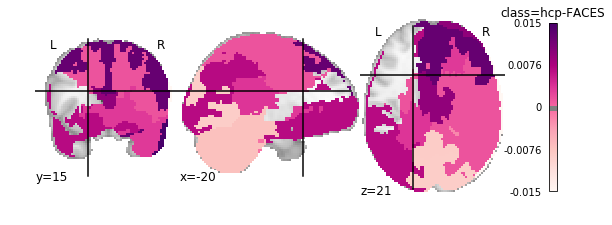

<Figure size 432x288 with 0 Axes>

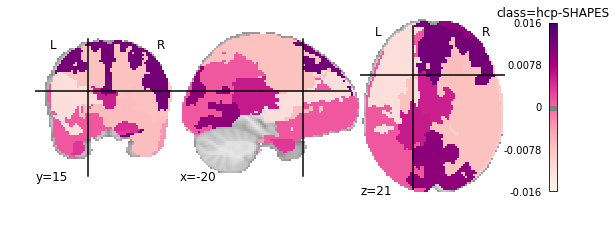

<Figure size 432x288 with 0 Axes>

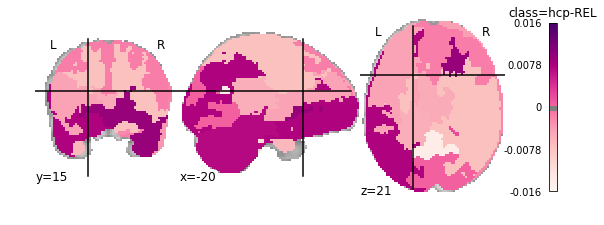

<Figure size 432x288 with 0 Axes>

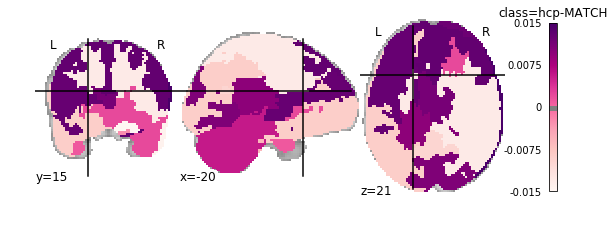

<Figure size 432x288 with 0 Axes>

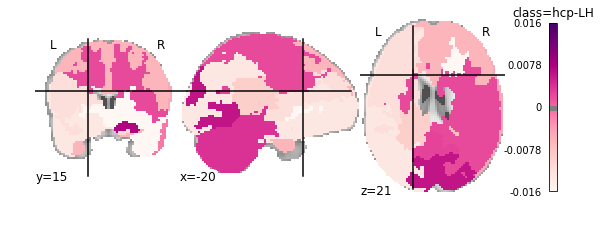

<Figure size 432x288 with 0 Axes>

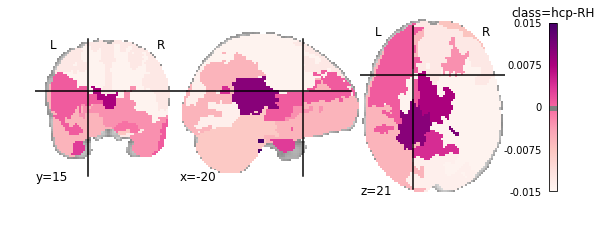

<Figure size 432x288 with 0 Axes>

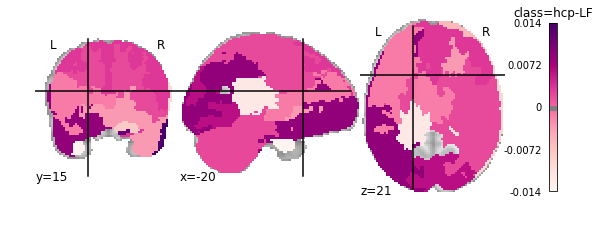

<Figure size 432x288 with 0 Axes>

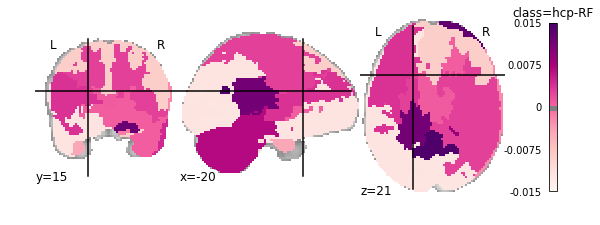

<Figure size 432x288 with 0 Axes>

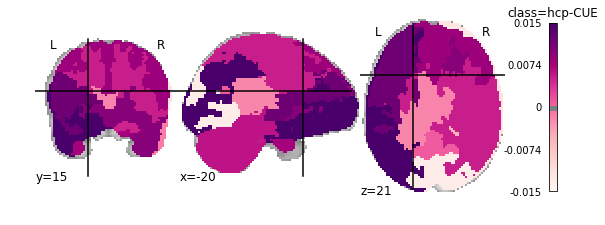

<Figure size 432x288 with 0 Axes>

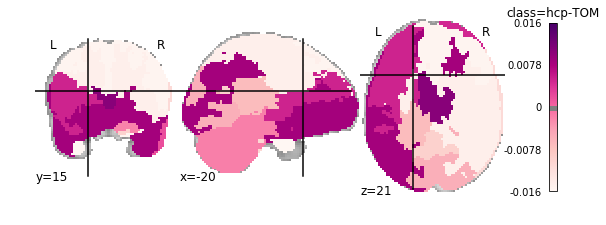

<Figure size 432x288 with 0 Axes>

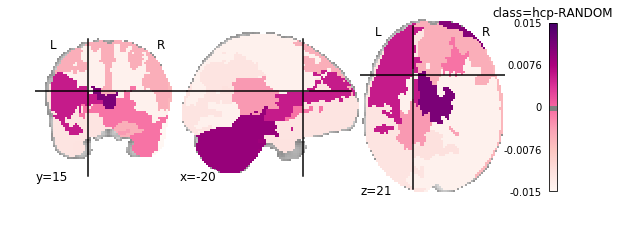

<Figure size 432x288 with 0 Axes>

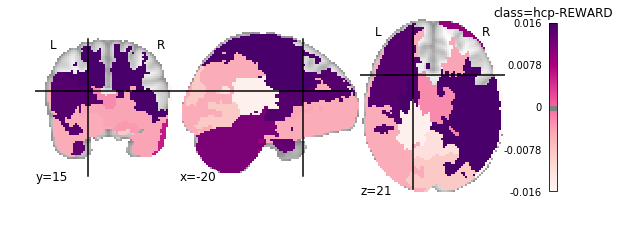

<Figure size 432x288 with 0 Axes>

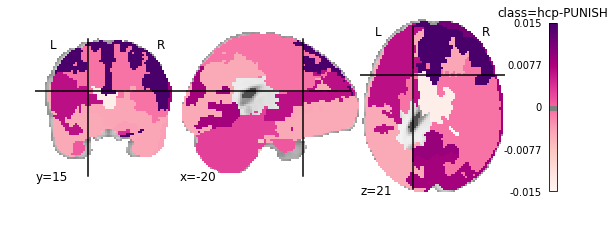

<Figure size 432x288 with 0 Axes>

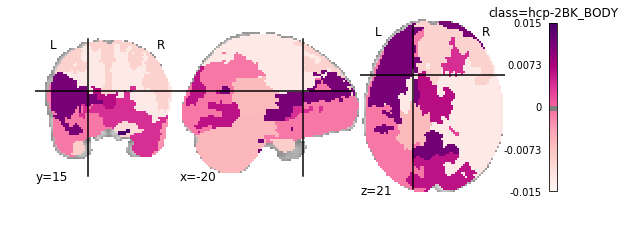

<Figure size 432x288 with 0 Axes>

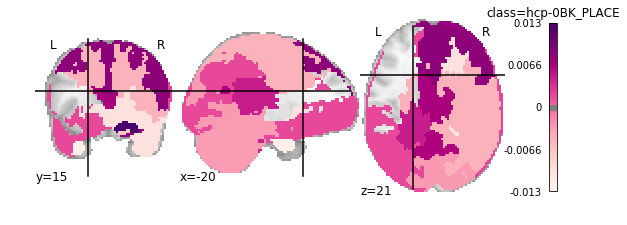

<Figure size 432x288 with 0 Axes>

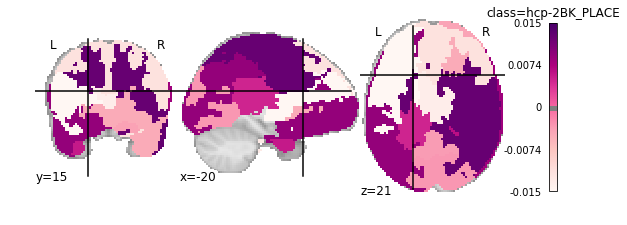

<Figure size 432x288 with 0 Axes>

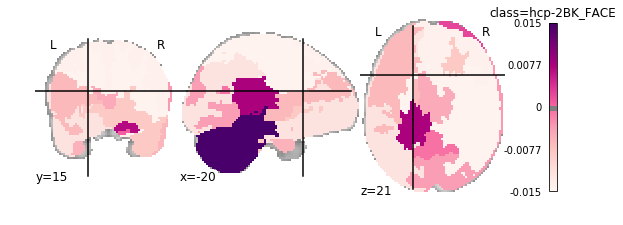

<Figure size 432x288 with 0 Axes>

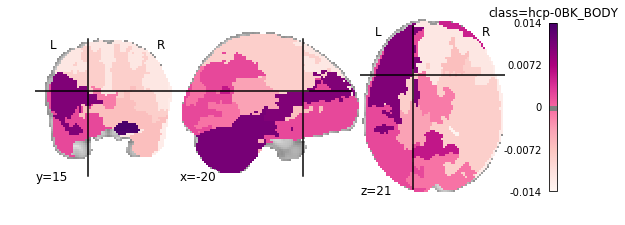

<Figure size 432x288 with 0 Axes>

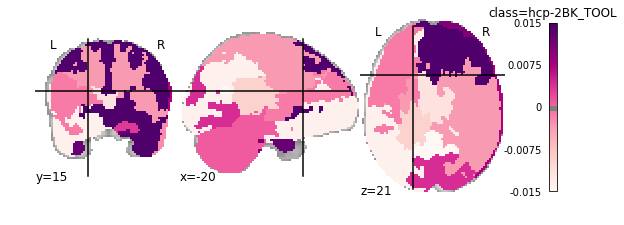

<Figure size 432x288 with 0 Axes>

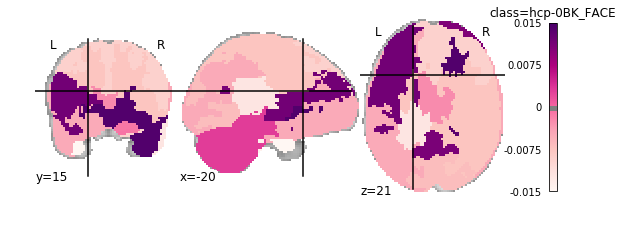

<Figure size 432x288 with 0 Axes>

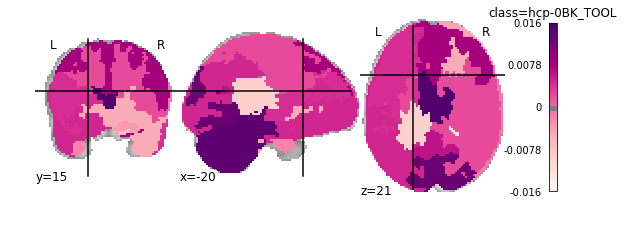

<Figure size 432x288 with 0 Axes>

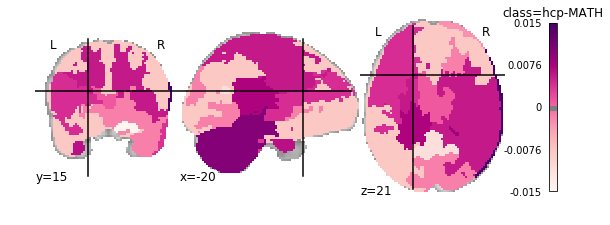

<Figure size 432x288 with 0 Axes>

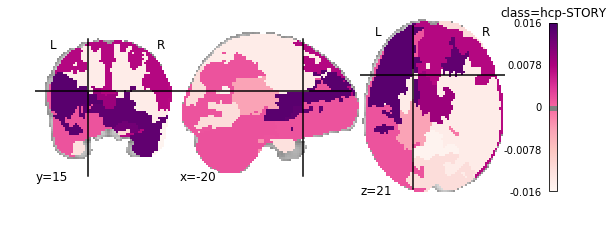

<Figure size 432x288 with 0 Axes>

In [59]:
cidx = 0
cls = 0
for cls in range(32):
    layer = 3
    plt.figure()
    plotting.plot_stat_map(
        get_niimg(layer, cls=cls, channel_idx=cidx, clip=1000000), 
        cmap=plt.get_cmap('RdPu'), 
        threshold=0.0005,
        cut_coords=[-20, 15, 21])
    plt.title('class={}'.format(meta['i2c'][cls]))

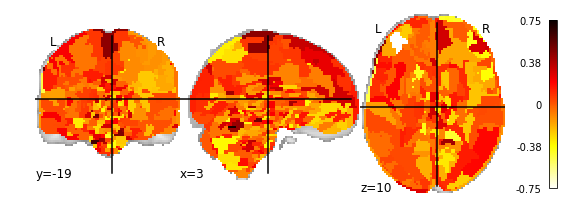

In [101]:
# Visualize the bias too - in case it matters. (Not the importance of the bias but the bias itself.)
plotting.plot_stat_map(get_bias_niimg(1, 0, 10), cmap=plt.get_cmap('hot_r'))

In [ ]:
plt.hist(model.downsample0.nf_weight_g.detach().cpu().numpy())

In [ ]:
plt.hist(model.downsample0.nf_weight_v.detach().view(-1).cpu().numpy())

In [43]:
model.downsample2.ft_weight

tensor([[-0.0880,  0.0256,  0.0021,  ..., -0.0383,  0.0809,  0.0514],
        [ 0.1141, -0.0430, -0.0877,  ...,  0.0891, -0.0127,  0.0107],
        [ 0.1334,  0.0116,  0.1285,  ..., -0.0912,  0.0337, -0.1150],
        ...,
        [-0.1071, -0.1035, -0.0546,  ..., -0.0607,  0.0477,  0.0771],
        [-0.0963,  0.0599,  0.0401,  ..., -0.0427,  0.0356,  0.1098],
        [ 0.0159, -0.0017, -0.0274,  ...,  0.0585, -0.0569,  0.0397]],
       grad_fn=<MulBackward0>)

In [45]:
model.downsample2.ft_weight_g * model.downsample2.ft_weight_v / norm_except_dim(model.downsample2.ft_weight_v, 2, 1)

tensor([[-0.0880,  0.0256,  0.0021,  ..., -0.0383,  0.0809,  0.0514],
        [ 0.1141, -0.0430, -0.0877,  ...,  0.0891, -0.0127,  0.0107],
        [ 0.1334,  0.0116,  0.1285,  ..., -0.0912,  0.0337, -0.1150],
        ...,
        [-0.1071, -0.1035, -0.0546,  ..., -0.0607,  0.0477,  0.0771],
        [-0.0963,  0.0599,  0.0401,  ..., -0.0427,  0.0356,  0.1098],
        [ 0.0159, -0.0017, -0.0274,  ...,  0.0585, -0.0569,  0.0397]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
### 1 layer FGL code

In [33]:
# Loading model
exp = "gcn"
md = "c1smallerfgl_213_sum_tree"
prefix = "test"
ds = "hcp0"
chk = torch.load("/data/brain_/{}/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format(exp, md, ds))
args = torch.load("/data/brain_/{}/outputs/multi_run/{}/{}/args.checkpoint".format(exp, md, ds))
splits, meta = dataset.get_splits(
    args.study,
    args.outer_folds,
    1,
    args.dset_seed,
    random_outer=args.outer_frac,  # test, always. Not CV
    random_inner=0.0,  # No validation.
    masked=classifiers.masked[args.classifier_type],
    downsampled=args.downsampled,
    normalization=args.normalization,
    not_lazy=args.not_lazy
)

model = classifiers.versions[args.classifier_type](args, loadable_state_dict=chk['model'])
model = model.cuda()
dpm = nn.DataParallel(model)
model = model.eval()

### Construct children
childrens = {}
parents = {}
for i in range(1, 2):
    layer = getattr(model, 'downsample{}'.format(i-1))
    parents[i] = layer.indices.detach().cpu().numpy()[0, 0]
    childrens[i] = [[] for _ in range(layer.outn)]
    inds = layer.indices[0, 0].detach().cpu().numpy().astype(np.int)
    for idx, par in enumerate(inds):
        childrens[i][par].append(idx)

p2i1 = [[] for _ in range(len(childrens[1]))]
for p in range(len(childrens[1])):
    p2i1[p].extend(childrens[1][p])

i12p = {}
for p, i1s in enumerate(p2i1):
    for i in i1s:
        i12p[i] = p

cs = {
    0: 1,
    1: model.downsample0.outc,
}  # Number of channels at each stage

ns = {
    0: model.downsample0.inn, 
    1: model.downsample0.outn, 
}  # Number ofnodes at each stage

# Model parameters follow
us = {}
vs = {}
with torch.no_grad():

    us[1] = (model.downsample0.nf_weight).detach().cpu().numpy()
#     us[2] = (model.downsample1.nf_weight).detach().cpu().numpy()
#     us[3] = (model.downsample2.nf_weight).detach().cpu().numpy()
    vs[1] = (model.downsample0.ft_weight).detach().cpu().numpy()
#     vs[2] = (model.downsample1.ft_weight).detach().cpu().numpy()
#     vs[3] = (model.downsample2.ft_weight).detach().cpu().numpy()

fglw = (model.fc[0].weight).detach().cpu().numpy() # (model.fc[0].weight_g * model.fc[0].weight_v).detach().cpu().numpy()  # Weight of fc layer
nclasses = fglw.shape[0]
fglw = np.reshape(fglw, (nclasses, cs[1], ns[1]))
# There was some confusion regarding how pytorch handles flattening. This should be correct.


### Construct importances
shallow_importances = {
    i: np.zeros((nclasses, cs[i], ns[i])) for i in range(1)
}
with torch.no_grad():
    # Start at layer 1's output
    shallow_importances[1] = fglw
    
    # Importances for layer 1's input
    tic = time.time()
    for c in range(nclasses):
        for i3 in range(ns[1]):
            p = parents[1][i3]
            shallow_importances[0][c, :, i3] += us[1][:, i3] @ np.diag(fglw[c, :, p]) @ vs[1].T
    print("importances[0]: {}".format(time.time() - tic))

Using corrected initialization
FGL: Using tree optimization
importances[0]: 0.18674325942993164


In [37]:
def get_shallow_niimg(layer_idx, cls=0, channel_idx=0, clip=0.1):
    arr = np.take(shallow_importances[layer_idx][cls, channel_idx, :], taking_indices[layer_idx])
    niimg = masking.unmask(np.clip(arr, -clip, clip), mask)
    return niimg

Text(0.5,1,'class=hcp-FACES')

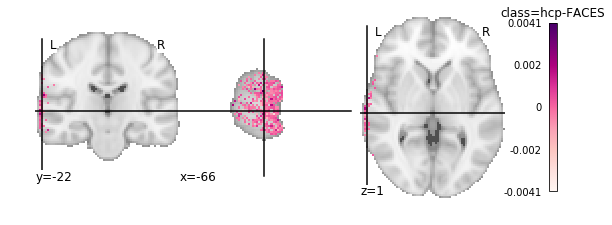

In [60]:
cidx = 0
cls = 0
layer = 0
plotting.plot_stat_map(
    get_shallow_niimg(layer, cls=cls, channel_idx=cidx, clip=1000000), 
    cmap=plt.get_cmap('RdPu'), 
    threshold='auto'),
#     cut_coords=[-20, 15, 21])
plt.title('class={}'.format(meta['i2c'][cls]))